In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np

In [3]:
from layers import conv_layer, max_pool_2x2, full_layer

DATA_DIR = '../../data'
MINIBATCH_SIZE = 50
STEPS = 1000

In [4]:
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../data/t10k-images-idx3-ubyte.gz
Extracting ../../data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [20]:
x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
print(conv1)
conv1_pool = max_pool_2x2(conv1)
print(conv1_pool)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

Tensor("Relu_24:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool_13:0", shape=(?, 14, 14, 32), dtype=float32)


In [6]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(STEPS):
        batch = mnist.train.next_batch(MINIBATCH_SIZE)

        if i % 100 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1],
                                                           keep_prob: 1.0})
            print("step {}, training accuracy {}".format(i, train_accuracy))

        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    X = mnist.test.images.reshape(10, 1000, 784)
    Y = mnist.test.labels.reshape(10, 1000, 10)
    test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))


step 0, training accuracy 0.019999999552965164
step 100, training accuracy 0.8399999737739563
step 200, training accuracy 0.9200000166893005
step 300, training accuracy 0.8799999952316284
step 400, training accuracy 0.9800000190734863
step 500, training accuracy 0.9599999785423279
step 600, training accuracy 0.9200000166893005
step 700, training accuracy 0.9399999976158142
step 800, training accuracy 0.9599999785423279
step 900, training accuracy 0.9200000166893005
test accuracy: 0.9624000787734985


In [8]:
import pickle
import os
import matplotlib.pyplot as plt

In [10]:
DATA_PATH = "./cifar-10-batches-py"
BATCH_SIZE = 50
STEPS = 10000

In [12]:
def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out


def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        u = pickle._Unpickler(fo)
        u.encoding = 'latin1'
        dict = u.load()
    return dict


def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
    plt.imshow(im)
    plt.show()


class CifarLoader(object):
    """
    Load and mange the CIFAR dataset.
    (for any practical use there is no reason not to use the built-in dataset handler instead)
    """
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None

    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1)\
            .astype(float) / 255
        self.labels = one_hot(np.hstack([d["labels"] for d in data]), 10)
        return self

    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size], \
               self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

    def random_batch(self, batch_size):
        n = len(self.images)
        ix = np.random.choice(n, batch_size)
        return self.images[ix], self.labels[ix]


class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1, 6)])\
            .load()
        self.test = CifarLoader(["test_batch"]).load()


In [13]:
def create_cifar_image():
    d = CifarDataManager()
    print("Number of train images: {}".format(len(d.train.images)))
    print("Number of train labels: {}".format(len(d.train.labels)))
    print("Number of test images: {}".format(len(d.test.images)))
    print("Number of test labels: {}".format(len(d.test.labels)))
    images = d.train.images
    display_cifar(images, 10)

In [ ]:
def run_simple_net():
    cifar = CifarDataManager()

    # image: 32*32*3(RGB)
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)

    # layer shape -> for truncated_normal shape
    conv1 = conv_layer(x, shape=[5, 5, 3, 32])
    conv1_pool = max_pool_2x2(conv1)

    conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
    conv2_pool = max_pool_2x2(conv2)

    conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
    conv3_pool = max_pool_2x2(conv3)
    conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])
    conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

    full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
    full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

    y_conv = full_layer(full1_drop, 10)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,
                                                                           labels=y_))
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def test(sess):
        X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
        Y = cifar.test.labels.reshape(10, 1000, 10)
        acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
                       for i in range(10)])
        print("Accuracy: {:.4}%".format(acc * 100))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(STEPS):
            batch = cifar.train.next_batch(BATCH_SIZE)
            sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

            if i % 500 == 0:
                print('step: '+str(i))
                test(sess)

        test(sess)

In [25]:
def build_second_net():
    cifar = CifarDataManager()
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)

    C1, C2, C3 = 32, 64, 128
    F1 = 600

    conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
    conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
    conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
    conv1_pool = max_pool_2x2(conv1_3)
    conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

    conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
    conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
    conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
    conv2_pool = max_pool_2x2(conv2_3)
    conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

    conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
    conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
    conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
    conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    conv3_flat = tf.reshape(conv3_pool, [-1, C3])
    conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

    full1 = tf.nn.relu(full_layer(conv3_drop, F1))
    full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)

    y_conv = full_layer(full1_drop, 10)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,
                                                                           labels=y_))
    train_step = tf.train.AdamOptimizer(5e-4).minimize(cross_entropy)  # noqa

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  # noqa

    def test(sess):
        X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
        Y = cifar.test.labels.reshape(10, 1000, 10)
        acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0})
                       for i in range(10)])
        print("Accuracy: {:.4}%".format(acc * 100))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(STEPS):
            batch = cifar.train.next_batch(BATCH_SIZE)
            sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

            if i % 500 == 0:
                print('step: '+str(i))
                test(sess)

        test(sess)

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


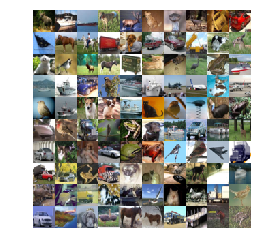

In [16]:
create_cifar_image()

In [17]:
run_simple_net()

Accuracy: 10.03%
Accuracy: 41.66%
Accuracy: 47.3%
Accuracy: 53.21%
Accuracy: 55.57%
Accuracy: 55.48%
Accuracy: 60.32%
Accuracy: 61.95%
Accuracy: 63.83%
Accuracy: 65.28%
Accuracy: 65.58%
Accuracy: 64.93%
Accuracy: 66.63%
Accuracy: 67.88%
Accuracy: 69.32%
Accuracy: 67.04%
Accuracy: 69.7%
Accuracy: 68.72%
Accuracy: 70.68%
Accuracy: 68.4%
Accuracy: 70.69%


In [26]:
build_second_net()

step: 0
Accuracy: 10.0%
step: 100
Accuracy: 13.01%
step: 200
Accuracy: 10.07%
step: 300
Accuracy: 10.55%
step: 400
Accuracy: 10.0%
step: 500
Accuracy: 12.36%
step: 600


KeyboardInterrupt: 

In [21]:
initial = tf.constant(0.1, shape=[3])
print(initial)

Tensor("Const_41:0", shape=(3,), dtype=float32)
